# PROBABILISTIC MOVEMENT PRIMITIVES - Reproduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits import mplot3d

## Define basis functions

In [2]:
numofbasis=0
def BasisFunction(t):
    ph1 = np.zeros(numofbasis)
    totsum = 0
    for i in range(numofbasis):
        ph1[i] = np.exp(-width * (t / tau_motionduration - center[i]) ** 2)
        totsum = totsum + ph1[i]
    ph1 = ph1 / totsum

    ph2 = np.zeros(numofbasis)
    totsum = 0
    for j in range(numofbasis):
        ph2[j] = np.exp(-width * ((t + dt) / tau_motionduration - center[j]) ** 2)
        totsum = totsum + ph2[j]
    ph2 = ph2 / totsum
    ph2 = (ph2 - ph1)/dt

    pex = np.zeros((Dim, numofbasis*dim))
    for i in range(dim):
        pex[i, i*numofbasis:(i+1)*numofbasis] = ph1
    for i in range(dim):
        pex[dim+i, i * numofbasis:(i+1)*numofbasis] = ph2

    return pex

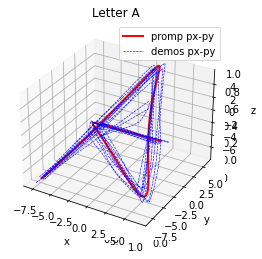

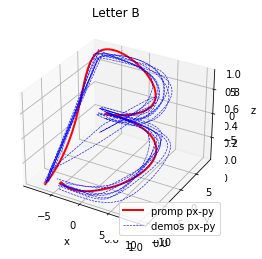

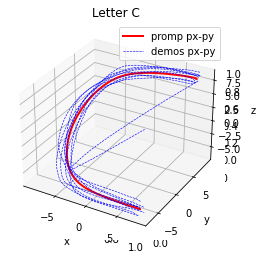

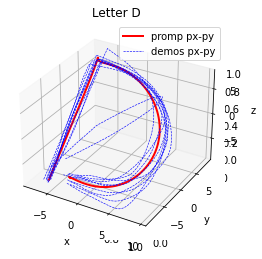

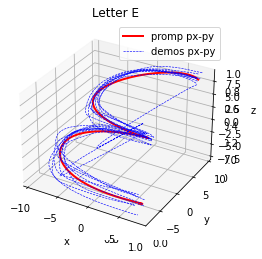

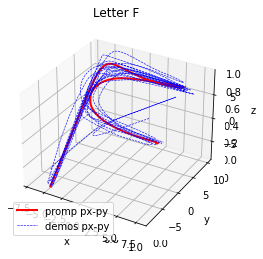

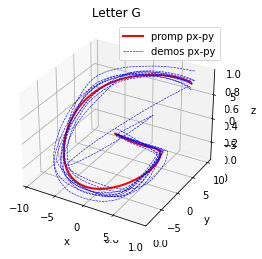

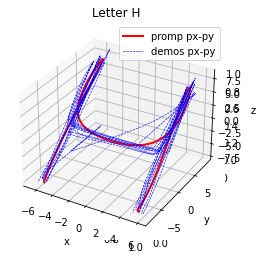

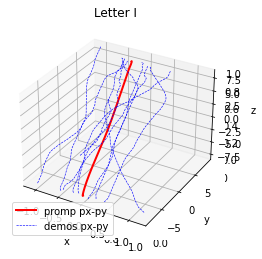

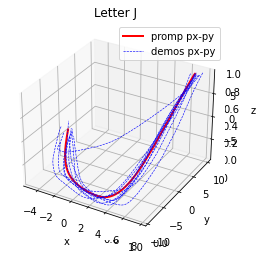

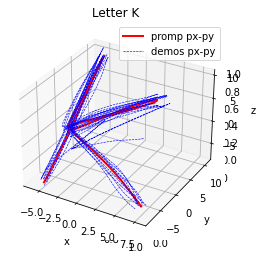

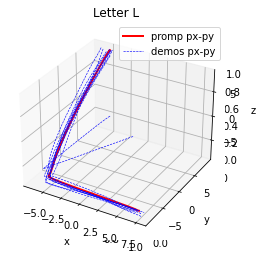

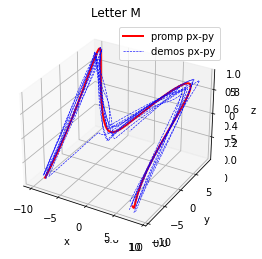

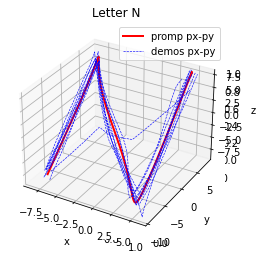

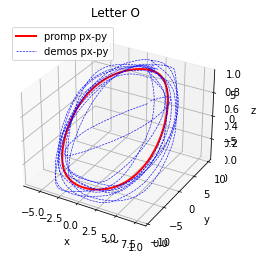

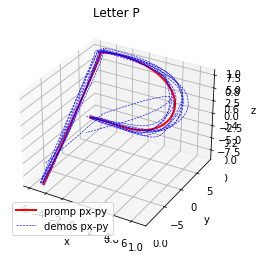

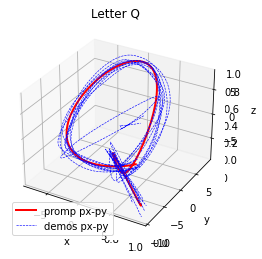

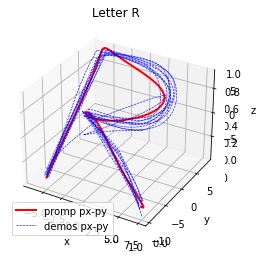

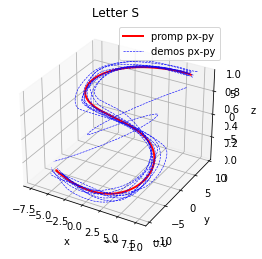

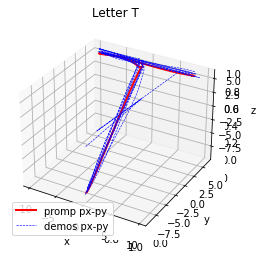

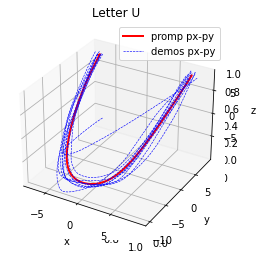

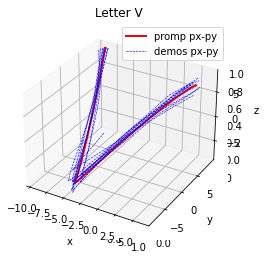

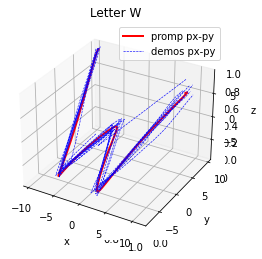

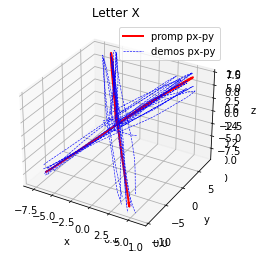

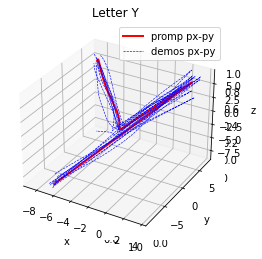

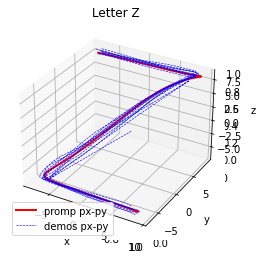

In [3]:
import string
for i in range(0,26):
    # LOAD THE TRAINING DATA #
    chrc=string.ascii_uppercase[i] #the letter is converted to uppercase
    mat = loadmat('2Dletters/'+chrc+'.mat') #nameofthe file
    #the letter is converted to uppercase
    numofdemo = 10 # number of demonstrations 
    dt = 0.005 # time interval
    posveldataset = [] #dataset for position velocity
    for i in range(numofdemo):
        pos = mat['demos'][0, i]['pos'][0, 0]
        vel = np.gradient(pos, axis=-1) / dt #returns the gradient of the array along the last axis
        pv = np.block([[pos], [vel]]) #concatenates pos and vel values
        posveldataset.append(pv)


    # Define variables and set parameters for ProMP #    
    dim=2
    Dim = 2 * dim # both position and velocity
    len = posveldataset[0].shape[1] # length of demonstrations
    tau_motionduration = dt * len # motion duration
    t0 = np.linspace(dt, tau_motionduration, num=len)
    center = np.linspace(0, 1, 10) # centers of basis functions, returns evenly spaced numbers
    numofbasis = center.shape[0] # number of basis functions
    width = 50 # width of basis functions
    lb1 = 1
    lb2 = 10


    # Estimate the distribution of the trajectory parameter vector w #
    Phi = np.zeros((Dim*len, numofbasis*dim))
    wts = np.zeros((numofdemo, numofbasis*dim))
    mu_w = np.zeros(numofbasis*dim)
    cov_w = np.zeros((numofbasis*dim, numofbasis*dim))
    for i in range(len):
        Phi[i*Dim:(i+1)*Dim, :] = BasisFunction(t0[i])
    PhiT_Phi = np.matmul(np.transpose(Phi), Phi) + lb1 * np.eye(numofbasis*dim)
    cw = np.matmul(np.linalg.pinv(PhiT_Phi), np.transpose(Phi))
    # Estimate the trajectory parameter vector w from each demonstration
    for i in range(numofdemo):
        expandedTraj = posveldataset[i].flatten(order='F')
        wts[i, :] = np.matmul(cw, expandedTraj)
    # Calculate the mean and covariance of w
    mu_w = np.mean(wts, axis=0)
    cov_w = np.matmul(np.transpose(wts - mu_w), wts - mu_w) / numofdemo + lb2 * np.eye(numofbasis*dim)


    # Prediction using probabilistic movement primitives #
    pred_pv = np.zeros((Dim, len))
    for i in range(len):
        pred_pv[:, i] = np.matmul(BasisFunction(t0[i]), mu_w)

    ax = plt.axes(projection='3d')

    mata = loadmat('2Dletters/'+ chrc +'.mat') #nameofthe file
    numofdemoa = 10 # number of demonstrations 
    dta = 0.005 # time interval
    posveldataseta = [] #dataset for position velocity
    for i in range(numofdemoa):
        posa = mata['demos'][0, i]['pos'][0, 0]
        vela = np.gradient(posa, axis=-1) / dt #returns the gradient of the array along the last axis
        pva = np.block([[posa], [vela]]) #concatenates pos and vel values
        posveldataseta.append(pva)

    lena = posveldataseta[0].shape[1] # length of demonstrations
    tau_motiondurationa = dta * lena # motion duration
    t0a = np.linspace(dta, tau_motiondurationa, num=lena)
    centera = np.linspace(0, 1, 10) # centers of basis functions, returns evenly spaced numbers
    numofbasisa = centera.shape[0] # number of basis functions



    # Estimate the distribution of the trajectory parameter vector w #
    Phia = np.zeros((Dim*lena, numofbasisa*dim))
    wtsa = np.zeros((numofdemoa, numofbasisa*dim))
    mu_wa = np.zeros(numofbasisa*dim)
    cov_wa= np.zeros((numofbasisa*dim, numofbasisa*dim))
    for i in range(lena):
        Phia[i*Dim:(i+1)*Dim, :] = BasisFunction(t0a[i])
    PhiT_Phia = np.matmul(np.transpose(Phia), Phia) + lb1 * np.eye(numofbasisa*dim)
    cwa = np.matmul(np.linalg.pinv(PhiT_Phia), np.transpose(Phia))
    # Estimate the trajectory parameter vector w from each demonstration
    for i in range(numofdemoa):
        expandedTraja = posveldataseta[i].flatten(order='F')
        wtsa[i, :] = np.matmul(cwa, expandedTraja)
    # Calculate the mean and covariance of w
    mu_wa = np.mean(wtsa, axis=0)
    cov_wa = np.matmul(np.transpose(wtsa - mu_wa), wtsa - mu_wa) / numofdemoa + lb2 * np.eye(numofbasisa*dim)


    # Prediction using probabilistic movement primitives #
    pred_pva = np.zeros((Dim, lena))
    for i in range(lena):
        pred_pva[:, i] = np.matmul(BasisFunction(t0a[i]), mu_wa)

    ax = plt.axes(projection='3d')

    # Plot predicted trajectories #
    ax.plot3D(pred_pv[0], pred_pv[1], pred_pva[1], 'r', label='promp px-py', linewidth=2)
    for i in range(numofdemo):
        if i == 0:
            ax.plot3D(posveldataset[i][0], posveldataset[i][1],posveldataseta[i][0], 'b--', linewidth=0.6, label='demos px-py')
        else:
            ax.plot3D(posveldataset[i][0], posveldataset[i][1],posveldataseta[i][1], 'b--', linewidth=0.6)
    titledisp='Letter '+chrc
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(titledisp)
    plt.legend()
    plt.show()

# PROBABILISTIC MOVEMENT PRIMITIVES - Adaptation

## Define the update function for trajectory parameters

In [4]:
def updatedistribution(t, desPoint, noisevar, mu_w, cov_w):
    Phi=BasisFunction(t)
    pred_pv = np.matmul(Phi,mu_w)
    sigma_Phi=np.matmul(cov_w, np.transpose(Phi))
    invL = np.linalg.pinv(np.matmul(Phi, sigma_Phi) + noisevar)
    sigma_Phi_invL = np.matmul(sigma_Phi, invL)
    mu_w_new = mu_w + np.matmul(sigma_Phi_invL, desPoint-pred_pv)
    cov_w_new = cov_w - np.matmul(sigma_Phi_invL, np.transpose(sigma_Phi))
    return mu_w_new, cov_w_new


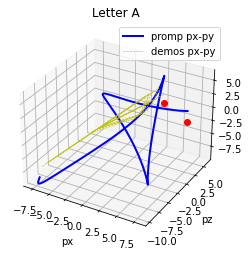

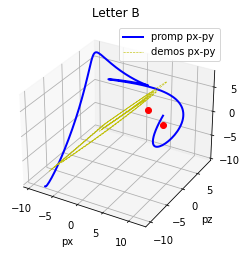

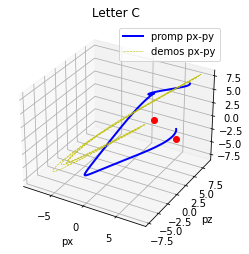

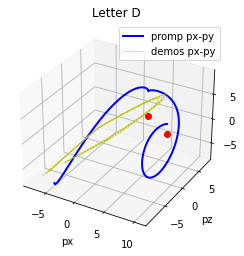

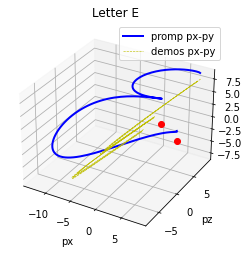

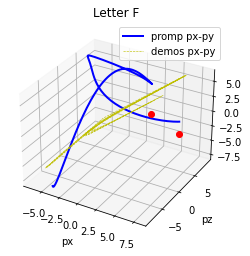

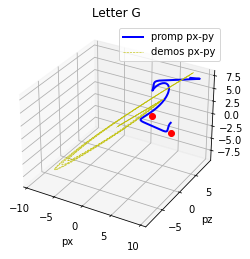

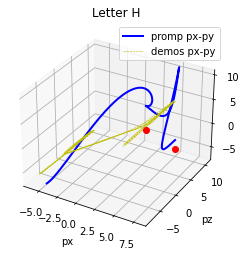

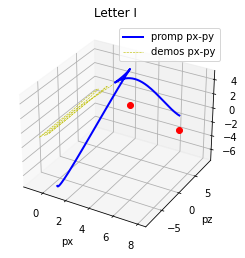

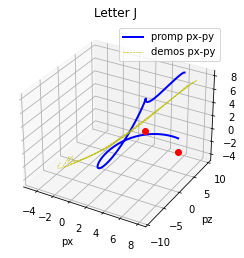

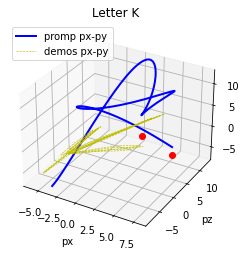

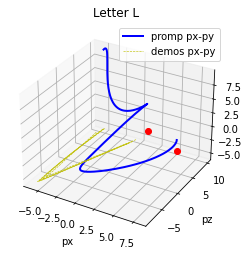

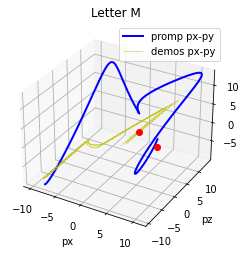

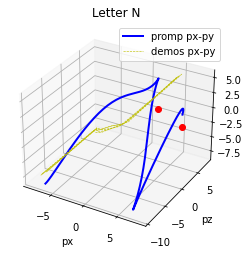

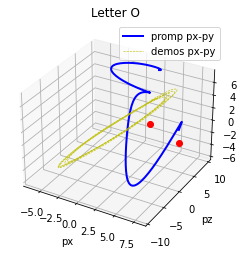

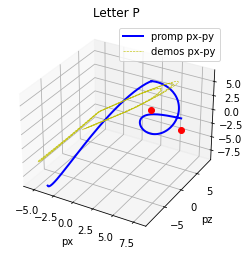

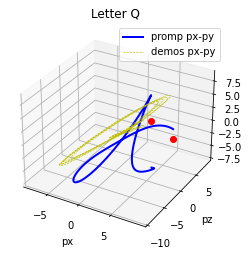

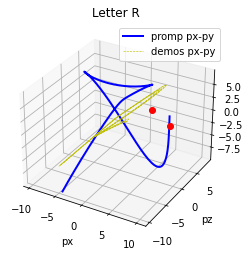

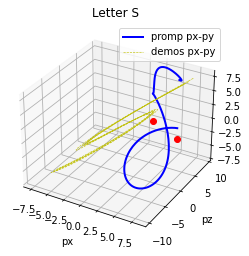

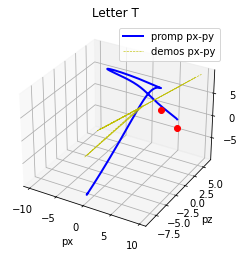

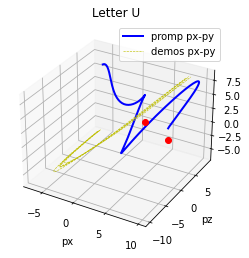

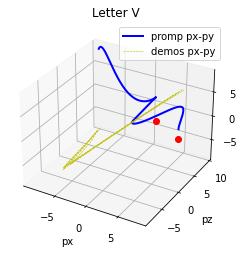

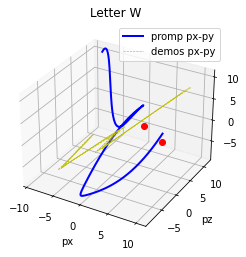

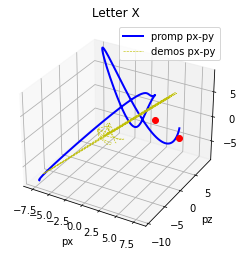

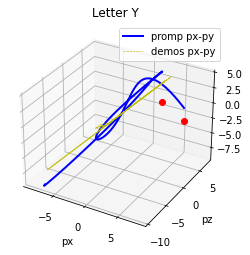

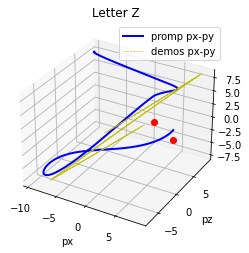

In [5]:
for i in range(0,26):
    # Load the training data
    ch=string.ascii_uppercase[i]
    mat = loadmat('2Dletters/'+ch+'.mat')
    numofdemo = 5 # number of demonstrations
    dt = 0.005 # time interval
    posveldataset = []
    for i in range(numofdemo):
        pos = mat['demos'][0, i]['pos'][0, 0]
        vel = np.gradient(pos, axis=-1) / dt
        pv = np.block([[pos], [vel]])
        posveldataset.append(pv)

    # Set parameters for ProMP
    dim = 2  # 2D trajectory
    Dim = 2 * dim # both position and velocity
    len = posveldataset[0].shape[1] # length of demonstrations
    tau_motionduration = dt * len # motion duration
    t0 = np.linspace(dt, tau_motionduration, num=len)
    center = np.linspace(0, 1, 20) # centers of basis functions
    numofbasis = center.shape[0]  # number of basis functions
    width = 50 # width of basis functions
    lb1 = 1
    lb2 = 10

    # Estimate the distribution of the trajectory parameter vector w
    Phi = np.zeros((Dim*len, numofbasis*dim))
    wts = np.zeros((numofdemo, numofbasis*dim))
    mu_w = np.zeros(numofbasis*dim)
    cov_w = np.zeros((numofbasis*dim, numofbasis*dim))

    for i in range(len):
        Phi[i*Dim:(i+1)*Dim, :] = BasisFunction(t0[i])
    PhiT_Phi = np.matmul(np.transpose(Phi), Phi) + lb1 * np.eye(numofbasis*dim)
    cw = np.matmul(np.linalg.pinv(PhiT_Phi), np.transpose(Phi))

    # Estimate the trajectory parameter vector w from each demonstration
    for i in range(numofdemo):
        trajectories_ext = posveldataset[i].flatten(order='F') # concatenate all columns into a column vector
        wts[i, :] = np.matmul(cw, trajectories_ext)

    # Calculate the mean and covariance of w
    mu_w = np.mean(wts, axis=0)
    cov_w = np.matmul(np.transpose(wts - mu_w), wts - mu_w) / numofdemo + lb2 * np.eye(numofbasis*dim)

    # Define desired points and modulate w
    via_time1 = 3.0/8
    via_point1 = np.array([3, 5, 0, 0]) # first desired point, format:[2D pos, 2D vel]
    via_time2 = 1.0
    via_point2 = np.array([8, 2, 0, 0]) # second desired point, format:[2D pos, 2D vel]

    via_var = 0.01 * np.eye(Dim) # inversely proportional to the adaptation precision

    # Update the distribution of w using each desired point
    [mu_w_new, cov_w_new] = updatedistribution(via_time1, via_point1, via_var, mu_w, cov_w)
    [mu_w_new, cov_w_new] = updatedistribution(via_time2, via_point2, via_var, mu_w_new, cov_w_new)

    # Prediction using ProMP
    pred_pv = np.zeros((Dim, len))
    for i in range(len):
        pred_pv[:, i] = np.matmul(BasisFunction(t0[i]), mu_w_new)
        
    matb = loadmat('2Dletters/'+ch+'.mat')
    posveldatasetb = []
    for i in range(numofdemo):
        posb = matb['demos'][0, i]['pos'][0, 0]
        velb = np.gradient(posb, axis=-1) / dt
        pvb = np.block([[posb], [velb]])
        posveldatasetb.append(pvb)

    # Set parameters for ProMP
    lenb = posveldatasetb[0].shape[1] # length of demonstrations
    tau_mdb = dt * lenb # motion duration
    tb0 = np.linspace(dt, tau_mdb, num=lenb)
    centerb = np.linspace(0, 1, 20) # centers of basis functions
    numofbasisb = centerb.shape[0]  # number of basis functions

    # Estimate the distribution of the trajectory parameter vector w
    B_Phi = np.zeros((Dim*lenb, numofbasisb*dim))
    B_wts = np.zeros((numofdemo, numofbasisb*dim))
    B_MuW = np.zeros(numofbasisb*dim)
    B_Covariance_W = np.zeros((numofbasisb*dim, numofbasisb*dim))

    for i in range(lenb):
        B_Phi[i*Dim:(i+1)*Dim, :] = BasisFunction(tb0[i])
    B_PhiT_Phi = np.matmul(np.transpose(B_Phi), B_Phi) + lb1 * np.eye(numofbasisb*dim)
    B_CW = np.matmul(np.linalg.pinv(B_PhiT_Phi), np.transpose(B_Phi))

    # Estimate the trajectory parameter vector w from each demonstration
    for i in range(numofdemo):
        adapt_trajectories = posveldatasetb[i].flatten(order='F') # concatenate all columns into a column vector
        B_wts[i, :] = np.matmul(B_CW, adapt_trajectories)

    # Calculate the mean and covariance of w
    B_MuW = np.mean(B_wts, axis=0)
    B_Covariance_W = np.matmul(np.transpose(B_wts - B_MuW), B_wts - B_MuW) / numofdemo + lb2 * np.eye(numofbasisb*dim)

    # Define desired points and modulate w
    viat1 = 3.0/8
    desiredpt1 = np.array([3, 5, 0, 0]) # first desired point, format:[2D pos, 2D velb]
    viat2 = 1.0
    desiredpt2 = np.array([8, 2, 0, 0]) # second desired point, format:[2D pos, 2D velb]

    via_var = 0.01 * np.eye(Dim) # inversely proportional to the adaptation precision

    # Update the distribution of w using each desired point
    [B_MuW_new, B_Covariance_W_new] = updatedistribution(viat1, desiredpt1, via_var, B_MuW, B_Covariance_W)
    [B_MuW_new, B_Covariance_W_new] = updatedistribution(viat2, desiredpt2, via_var, B_MuW_new, B_Covariance_W_new)

    # Prediction using ProMP
    pred_pvb = np.zeros((Dim, lenb))
    for i in range(lenb):
        pred_pvb[:, i] = np.matmul(BasisFunction(tb0[i]), B_MuW_new)

    # Plot predicted trajectories
    ax=plt.axes(projection='3d')
    ax.plot(pred_pv[0], pred_pv[1],pred_pvb[1], 'b', label='promp px-py', linewidth=2)
    for i in range(numofdemo):
        if i == 0:
            ax.plot(posveldataset[i][0], posveldataset[i][1], posveldatasetb[i][0], 'y--', linewidth=0.6, label='demos px-py')
        else:
            ax.plot(posveldataset[i][0], posveldataset[i][1],posveldatasetb[i][0], 'y--', linewidth=0.6)
    ax.plot(via_point1[0], via_point1[1], 'ro')
    ax.plot(via_point2[0], via_point2[1], 'ro')
    ax.set_xlabel("px")
    ax.set_ylabel("py")
    ax.set_ylabel("pz")
    ax.set_title('Letter '+ch)
    
    plt.legend()
    plt.show()

    